# Using cross-correlation on Spectrogram  to detect blue whale calls
#### Lakshay Sahni

## 1. Introduction



using data from a ocean-bottom seismometer with a sample rate of 50 Hz.We can only resolve signals of frequenies up to 1/2 the sample rate of an instrument.

In [63]:
import os
import scipy.io.wavfile as siow
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
import matplotlib.colors as color
import matplotlib.animation as animation

###  Read audio (.wav) files
 

In [64]:
os.chdir('/Users/lakshaysahni/desktop/Research/Whale-detection') # path to your local repo here

### function to visualize a whale call 

*wav_spectogram*
makes the timeseries and spectrogram plots. 

In [83]:
def wav_spectogram(samp, data): # function used later to plot timeseries and spectrograms
    
    [b,a] = sig.butter(4,[8/samp, 20/samp],'bandpass','ba') #filter data to spectral bands where B-call is
    data1 = sig.filtfilt(b, a, data)
    
    #data = data.flatten()
    data_length = data.size
    times = np.arange(data_length)/samp

    #plot timeseries on upper axis
    plt.figure(1, figsize=(9, 3))
    plt.subplot(211)
    plt.plot(times[10:],data1[10:])
    plt.axis([min(times), max(times), min(data1[10:]), max(data1[10:])])
    plt.xlabel('Seconds')
    plt.ylabel('Amplitude')

    #plot spectrogram on lower axis
    [f, t, Sxx] = sig.spectrogram(data1, samp, 'hann',samp*4,int(samp*3.8))
    cmap = plt.get_cmap('magma')
    norm = color.Normalize(vmin=np.amin(np.log10(Sxx))+12, vmax=np.amax(np.log10(Sxx)))
    plt.subplot(212)
    plt.pcolormesh(t, f, np.log10(Sxx), cmap=cmap, norm=norm)    
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.ylim([12, 18])
    return [f, t, Sxx]




## Data Science Results for Strong and weak whale calls


#### strong whale calls :  calls that were emmitted close to our sensor

Spectograms show the changes in power recorded at different frequencies over time. Dark colors represent low power, while bright colors represent high power. 


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  """Entry point for launching an IPython kernel.


(15000,)


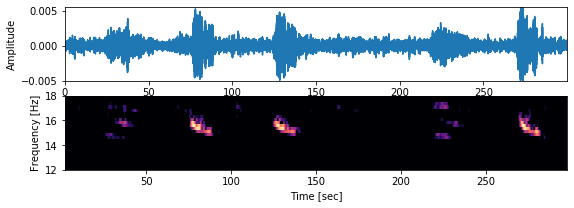

In [82]:
[samp, data] = siow.read('strongCalls1.wav', mmap=False)

print(data.shape)

[f, t, Sxx] =wav_spectogram(samp, data)

In [67]:
1000000-268237


731763

###  Weak whale calls


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  """Entry point for launching an IPython kernel.


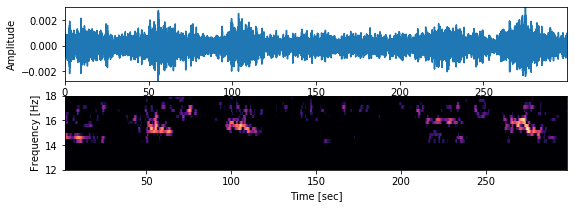

In [68]:
[samp, data] = siow.read('weakCalls.wav', mmap=False)
[f, t, Sxx] =wav_spectogram(samp, data)

##  Spectogram Cross-Correlation Methods



## Build a function to build a kernel
function to build a kernel to cross-correlate with our spectrograms to detect blue whale calls. 


In [84]:
def kernel_maker(f0, f1, bdwdth, dur, f, t, samp):
    tvec = np.linspace(0,dur,np.size(np.nonzero(t < dur))) #define kernel as length dur
    fvec = f #define frequency span of kernel to match spectrogram
    Kdist = np.zeros((np.size(tvec), np.size(fvec))) #preallocate space for kernel values
    j=0
    for j in range(np.size(tvec)):
        #calculate hat function that is centered on linearly decresing
        #frequency values for each time in tvec
        x = fvec-(f0+(t[j]/dur)*(f1-f0))
        Kval = (1-np.square(x)/(bdwdth*bdwdth))*np.exp(-np.square(x)/(2*(bdwdth*bdwdth)))
        Kdist[j] = Kval #store hat function values in preallocated array
                                                           
    BlueKernel = np.transpose(Kdist) #transpose preallocated array to be plotted vs. tvec and fvec
    return [tvec, fvec, BlueKernel]


## Build a kernel
*kernel_maker*  builds kernel tuned to our specified parameters.

Text(0.5, 1.0, 'Blue whale B-call kernel')

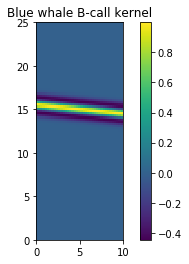

In [86]:
f0 = 15.7 #average start frequency
f1 = 14.4 #average end frequency
bdwdth = 0.5 # average bandwidth
dur = 10 #average duration
[tvec, fvec, BlueKernel] = kernel_maker(f0, f1, bdwdth, dur, f, t, samp) #build kernel from input parameters
plt.pcolormesh(tvec, fvec, BlueKernel) #show plot of kernel
plt.axis([0, 10, 0, 25])
plt.gca().set_aspect('equal')
plt.colorbar()
plt.title('Blue whale B-call kernel')

This kernel has positive values in the shape of the expected whale call, negative values bounding it to prevent false positives from signals outside of the expected range, and zero values everywhere else.

## Cross-correlate our kernel and our spectrogram

reads a .wav file, and make a spectrogram of 20,000 seconds of data in preparation for cross-correlation to test our detection kernel. 

1000000


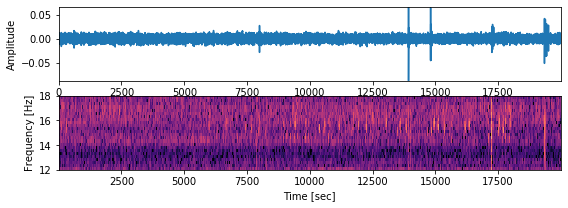

In [90]:
[samp, data] = siow.read('Test_data.wav', mmap=False)
print(len(data))
[f, t, Sxx] = wav_spectogram(samp, data)


This cross-correlate the kernel and the spectrogram of our test dataset. We do this by "sliding" the kernel across the spectrogram and summing the element-wise multiplication of each overlapping frame. The results of our cross-correlation will give us as time series with a "detection score" for each point in time.

In [93]:
ind1 = 0
CorrVal = np.zeros((np.size(t) - 39)) #preallocate array for correlation values
corrchunk= np.zeros((np.size(fvec), np.size(tvec))) #preallocate array for element-wise multiplication

while ind1-1+np.size(tvec) < np.size(t):
    ind2 = ind1 + np.size(tvec) #indices of spectrogram subset to multiply
    for indF in range(np.size(fvec)-1):
        corrchunk[indF] = Sxx[indF][ind1:ind2] #grab spectrogram subset for multiplication
        
    CorrVal[ind1] = np.sum(np.multiply(BlueKernel, corrchunk)) #save cross-correlation value for each frame
    ind1 += 1
    
    


## Visualize the Spectrogram


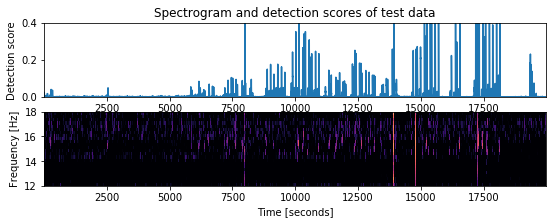

In [94]:
t1=min(t)
t2=max(t)
#plot timeseries on upper axis
plt.figure(1, figsize=(9, 3))
plt.subplot(211)
plt.plot(t[19:-20],CorrVal/max(CorrVal)) #plot normalized detection scores as a time series.
plt.axis([t1, t2, 0, .4]) #look at only positive values
plt.xlabel('Seconds')
plt.ylabel('Detection score')
plt.title('Spectrogram and detection scores of test data')

#plot spectrogram on lower axis
cmap = plt.get_cmap('magma')
norm = color.Normalize(vmin=np.amin(np.log10(Sxx))+15, vmax=np.amax(np.log10(Sxx)))
plt.subplot(212)
plt.pcolormesh(t, f, np.log10(Sxx), cmap=cmap, norm=norm)   
plt.axis([t1, t2, 12, 18]) #look at spectrogram segment between given time boundaries
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [seconds]')

plt.savefig('Spectrogram_scores.png')
